# Whakauru Steam Worked Example (slope detection power)

Before we get too far, lets import the necessary libraries and set up the notebook.

In [23]:
from komanawa.gw_detect_power import DetectionPowerSlope, AutoDetectionPowerSlope
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from komanawa.kendall_stats import MannKendall
import datetime
from komanawa.gw_age_tools import check_age_inputs, predict_historical_source_conc, predict_future_conc_bepm
from scipy.interpolate import interp1d


## Background and site description

The Whakauru Stream is a dominantly spring-fed spring in the Pokawhenua catchment in the Waikato region of New Zealand.  The catchment is dominated by dairy farming and forestry.  Several water age analyses have been conducted at the site and the mean age of the water is approximately 12 years.  


## Step 1: Assess the historical data

Read in the data.  Typically, this would be from an external file, but for reproducibility we will hard code the data into this notebook.

       n       date
0  0.079 2004-01-27
1  0.085 2004-02-23
2  0.052 2004-03-22
3  0.045 2004-04-26
4  0.095 2004-05-24


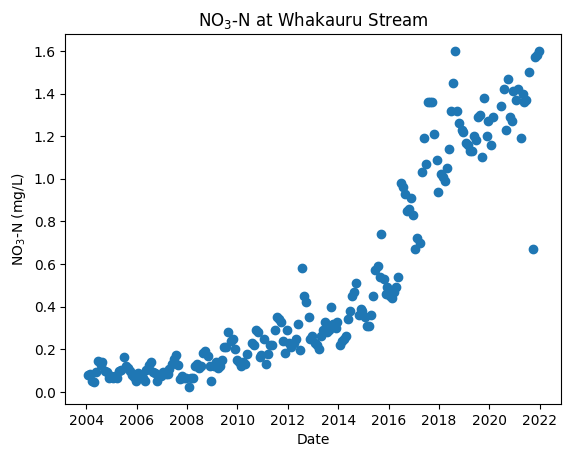

In [24]:
raw_n_vals = np.array([0.079, 0.085, 0.052, 0.045, 0.095, 0.143, 0.125, 0.141, 0.098,
                       0.091, 0.065, 0.072, 0.064, 0.072, 0.065, 0.1, 0.103, 0.164,
                       0.123, 0.113, 0.099, 0.079, 0.068, 0.053, 0.087, 0.07, 0.065,
                       0.05, 0.101, 0.127, 0.14, 0.094, 0.086, 0.051, 0.079, 0.072,
                       0.094, 0.082, 0.084, 0.105, 0.13, 0.153, 0.174, 0.128, 0.061,
                       0.075, 0.066, 0.067, 0.023, 0.066, 0.064, 0.12, 0.13, 0.11,
                       0.12, 0.18, 0.19, 0.17, 0.12, 0.051, 0.12, 0.14, 0.11,
                       0.12, 0.15, 0.21, 0.21, 0.28, 0.24, 0.25, 0.2, 0.15,
                       0.14, 0.12, 0.14, 0.132, 0.176, 0.23, 0.22, 0.29, 0.28,
                       0.164, 0.171, 0.25, 0.131, 0.178, 0.22, 0.22, 0.29, 0.35,
                       0.34, 0.33, 0.24, 0.183, 0.29, 0.23, 0.21, 0.23, 0.25,
                       0.32, 0.197, 0.58, 0.45, 0.42, 0.35, 0.25, 0.26, 0.23,
                       0.22, 0.2, 0.26, 0.29, 0.33, 0.28, 0.29, 0.4, 0.32,
                       0.3, 0.33, 0.22, 0.24, 0.25, 0.26, 0.34, 0.38, 0.45,
                       0.47, 0.51, 0.36, 0.39, 0.38, 0.35, 0.31, 0.31, 0.36,
                       0.45, 0.57, 0.59, 0.54, 0.74, 0.53, 0.46, 0.49, 0.45,
                       0.44, 0.47, 0.49, 0.54, 0.98, 0.96, 0.93, 0.85, 0.86,
                       0.91, 0.83, 0.67, 0.72, 0.7, 1.03, 1.19, 1.07, 1.36,
                       1.36, 1.36, 1.21, 1.09, 0.94, 1.02, 1.01, 0.99, 1.05,
                       1.14, 1.32, 1.45, 1.6, 1.32, 1.26, 1.23, 1.22, 1.17,
                       1.16, 1.13, 1.13, 1.2, 1.18, 1.29, 1.3, 1.1, 1.38,
                       1.2, 1.27, 1.16, 1.29, 1.34, 1.42, 1.23, 1.47, 1.29,
                       1.27, 1.41, 1.37, 1.42, 1.19, 1.4, 1.36, 1.37, 1.5,
                       0.67, 1.57, 1.58, 1.6])

raw_n_dates = np.array(
    ['2004-01-27', '2004-02-23', '2004-03-22', '2004-04-26', '2004-05-24', '2004-06-22', '2004-07-27', '2004-08-23',
     '2004-09-28', '2004-10-25', '2004-11-22', '2004-12-20', '2005-01-24', '2005-02-20', '2005-03-22', '2005-04-26',
     '2005-05-24', '2005-06-27', '2005-07-25', '2005-08-23', '2005-09-28', '2005-10-24', '2005-11-21', '2005-12-18',
     '2006-01-23', '2006-02-20', '2006-03-29', '2006-04-26', '2006-05-22', '2006-06-27', '2006-07-23', '2006-08-22',
     '2006-09-25', '2006-10-24', '2006-11-27', '2006-12-19', '2007-01-23', '2007-02-27', '2007-03-27', '2007-04-23',
     '2007-05-29', '2007-06-25', '2007-07-24', '2007-08-27', '2007-09-23', '2007-10-23', '2007-11-25', '2007-12-16',
     '2008-01-29', '2008-02-26', '2008-03-25', '2008-04-21', '2008-05-28', '2008-06-24', '2008-07-21', '2008-08-25',
     '2008-09-22', '2008-10-27', '2008-11-25', '2008-12-16', '2009-01-27', '2009-02-23', '2009-03-24', '2009-04-27',
     '2009-05-27', '2009-06-22', '2009-07-27', '2009-08-24', '2009-09-28', '2009-10-26', '2009-11-23', '2009-12-21',
     '2010-01-24', '2010-02-21', '2010-03-22', '2010-04-27', '2010-05-24', '2010-07-28', '2010-08-24', '2010-09-27',
     '2010-10-25', '2010-11-21', '2010-12-14', '2011-01-24', '2011-02-21', '2011-03-21', '2011-04-26', '2011-05-24',
     '2011-06-28', '2011-07-26', '2011-08-22', '2011-09-26', '2011-10-24', '2011-11-21', '2011-12-19', '2012-01-25',
     '2012-02-15', '2012-03-26', '2012-04-25', '2012-05-28', '2012-06-26', '2012-07-23', '2012-08-28', '2012-09-24',
     '2012-10-28', '2012-11-25', '2012-12-18', '2013-01-28', '2013-02-25', '2013-03-25', '2013-04-22', '2013-05-28',
     '2013-06-24', '2013-07-23', '2013-08-26', '2013-09-23', '2013-10-21', '2013-11-25', '2013-12-15', '2014-01-27',
     '2014-02-24', '2014-03-24', '2014-04-21', '2014-05-27', '2014-06-24', '2014-07-22', '2014-08-25', '2014-09-22',
     '2014-10-27', '2014-11-24', '2014-12-15', '2015-01-26', '2015-02-25', '2015-03-23', '2015-04-28', '2015-05-26',
     '2015-06-23', '2015-07-28', '2015-08-25', '2015-09-20', '2015-10-26', '2015-11-23', '2015-12-15', '2016-01-25',
     '2016-02-22', '2016-03-21', '2016-04-25', '2016-05-23', '2016-06-27', '2016-07-25', '2016-08-23', '2016-09-26',
     '2016-10-24', '2016-11-21', '2016-12-14', '2017-01-23', '2017-02-21', '2017-03-27', '2017-04-25', '2017-05-22',
     '2017-06-26', '2017-07-24', '2017-08-21', '2017-09-25', '2017-10-23', '2017-11-27', '2017-12-18', '2018-01-29',
     '2018-02-26', '2018-03-26', '2018-04-22', '2018-05-22', '2018-06-26', '2018-07-23', '2018-08-27', '2018-09-24',
     '2018-10-22', '2018-11-26', '2018-12-17', '2019-01-28', '2019-02-25', '2019-03-25', '2019-04-22', '2019-05-27',
     '2019-06-24', '2019-07-22', '2019-08-26', '2019-09-23', '2019-10-21', '2019-11-25', '2019-12-17', '2020-01-27',
     '2020-02-24', '2020-06-22', '2020-07-28', '2020-08-24', '2020-09-21', '2020-10-26', '2020-11-24', '2020-12-15',
     '2021-01-26', '2021-02-23', '2021-03-29', '2021-04-27', '2021-05-18', '2021-06-21', '2021-07-26', '2021-09-22',
     '2021-10-25', '2021-11-22', '2021-12-19']

)

ndata = pd.DataFrame({'n': raw_n_vals, 'date': pd.to_datetime(raw_n_dates)})

print(ndata.head())

fig, ax = plt.subplots()
ax.scatter(ndata['date'], ndata['n'])
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('NO$_{3}$-N at Whakauru Stream')
plt.show()


### Look for and possibly remove outliers 

There is clearly some variability in the data and the concentration of nitrate-nitrogen increases drastically after 2010.  Anecdotally, we know that there was a large increase in dairy farming in the catchment.  We will therefore remove any data before 2010-01-01 to focus the recent changes in the stream.  There is also one anomalous data point in 2022.  We will remove this data point as well.

In [25]:
ndata = ndata.set_index('date')
ndata = ndata.sort_index()
ndata = ndata.loc[~((ndata.index > '2020-01-01') & (ndata['n'] < 0.8))]
ndata = ndata.loc['2010-01-01':]

### Identify historical trends

The next step it to identify and describe any historical trend in the data. We will use a Mann Kendall test as it is non-parametric and does not require the data to be normally distributed.

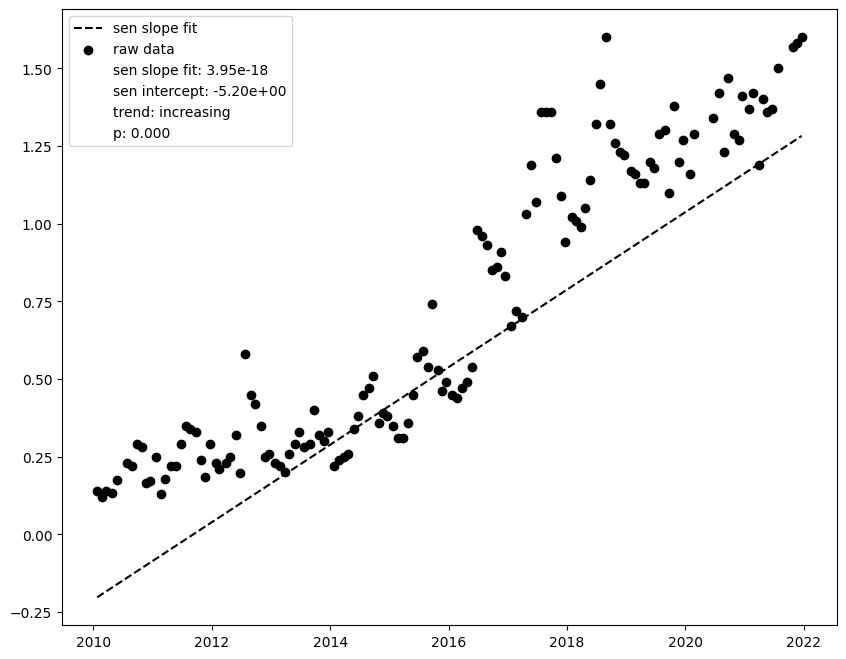

In [26]:
mk = MannKendall(ndata['n'], alpha=0.05)
mk.plot_data()
plt.show()

##  Step 2: Estimate the noise level

When it comes to estimating the variance of the data we can either use the standard deviation of the data or we can use the standard deviation of the residuals to a modelled value.  In this case we will use the standard deviation of the residuals to the sen slope and sen intercept from the Mann Kendall test.  This reduces the variance in the dataset as we are explaining much of the variation in the data with the trend.  More complicated models could be used (e.g., accounting for seasonal changes in the concentration), but for this example just accounting for the trend is sufficient.

The standard deviation of the data is:  0.47
The standard deviation of the residuals is:  0.17


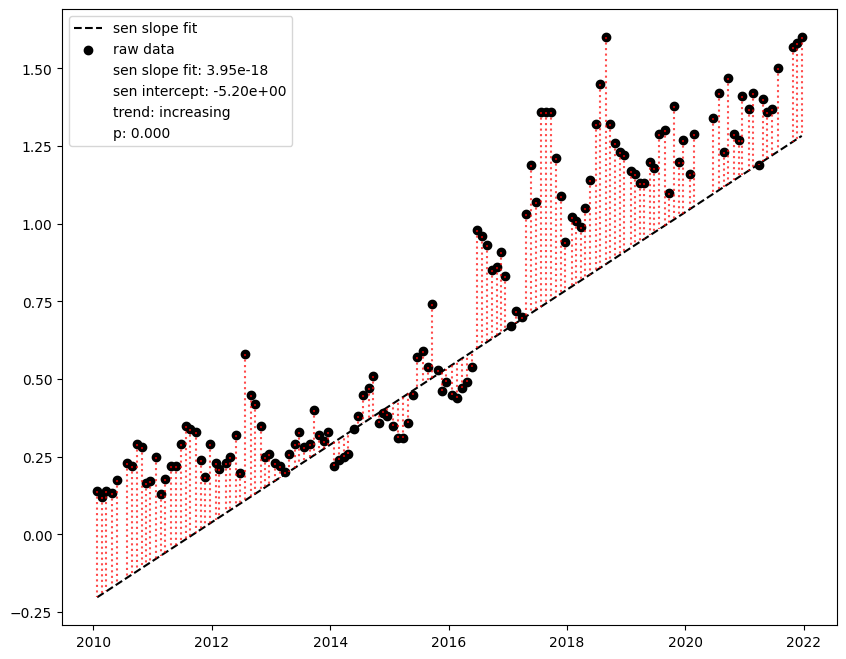

In [27]:
print('The standard deviation of the data is: ', round(ndata['n'].std(), 2))
senslope, senintercept, lo_slope, up_slope = mk.calc_senslope()
ndata['predicted'] = senslope * ndata.index.values.astype(float) + senintercept
ndata['residual'] = ndata['n'] - ndata['predicted']

input_error = ndata['residual'].std()

print('The standard deviation of the residuals is: ', round(input_error, 2))

fig, ax, (handles, labels) = mk.plot_data()
for i, row in ndata.iterrows():
    ax.plot([i, i], [row['n'], row['predicted']], color='red', ls=':', alpha=0.7)
plt.show()

## Step 3: Estimate the likely historical source concentration

We know that the Whakauru Stream has lag, and that lag is best described via an exponential piston flow model. All of our possible scenarios involve reductions to the average concentration in the source area of Whakauru Stream. Unfortunately, the source zone and the relative contributions of different land uses in that source zone is unknown.  Therefore, we need to estimate the likely historical source concentration.  We can do this as follows (other mechanisms to estimate the source concentration may be more appropriate for your site, but this is a good starting point).


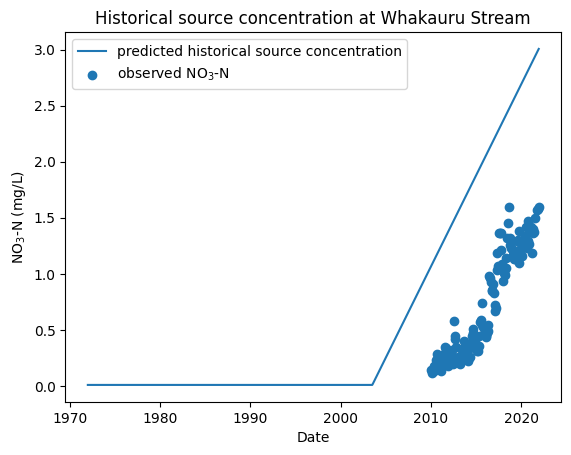

In [28]:
mrt = 12
mrt_p1 = 12
mrt_p2 = 12  # dummy value (only one EPM)
frac_p1 = 1
precision = 2  # calculate the historical source  at 0.01-year intervals (roughly monthly)
f_p1 = 0.7
f_p2 = 0.7  # dummy value (only one EPM)

max_conc = 10  # maximum concentration the source area could have
min_conc = .01  # minimum concentration the source area could have
p0 = None  # no guess for scipy curve fit

# calculate the historical slope in units years from 2014-01-01 instead of datetime
ndata_yr = ndata.copy()
ndata_yr['yr'] = (ndata_yr.index - ndata_yr.index.min()).days / 365.25
ndata_yr = ndata_yr.set_index('yr')
mk = MannKendall(ndata_yr['n'], alpha=0.05)
senslope, senintercept, lo_slope, up_slope = mk.calc_senslope()
prev_slope = senslope

# use the last time step sen fit as the initial concentration
init_conc = ndata_yr.index[-1] * senslope + senintercept

# check the age inputs
mrt, mrt_p2 = check_age_inputs(mrt, mrt_p1, mrt_p2, frac_p1, precision, f_p1, f_p2)
start_age = max(mrt, mrt_p1, mrt_p2, 30)

# predict the historical source concentration
hist = predict_historical_source_conc(init_conc, mrt, mrt_p1, mrt_p2, frac_p1, f_p1, f_p2, prev_slope, max_conc,
                                      min_conc, start_age=start_age, precision=precision, p0=p0)

hist.name = 'source_conc'
hist.index.name = 'yr_from_present'

hist = pd.DataFrame(hist).reset_index()
hist['date'] = [ndata.index.max().date() + datetime.timedelta(days=e) for e in hist['yr_from_present'] * 365.25]

# plot the historical source concentration
fig, ax = plt.subplots()
idx = hist['yr_from_present'] > -50
ax.plot(hist.loc[idx, 'date'], hist.loc[idx, 'source_conc'], label='predicted historical source concentration')
ax.scatter(ndata.index, ndata['n'], label='observed NO$_{3}$-N')
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('Historical source concentration at Whakauru Stream')
ax.legend()
plt.show()

## Step 4: Generate the future scenarios
From this point we can generate the future scenarios. For this example we will look at a reduction in the source concentration to 1.5 mg/l implemented over 20 years and then concentrations will stay static. We will also create a “base” scenario where source concentrations stay static.

In [29]:
base_scenario_source_conc = hist.set_index('yr_from_present')['source_conc']
alt_scenario_source_conc = base_scenario_source_conc.copy()

target_conc = 1.5

base_scenario_source_conc.loc[20] = base_scenario_source_conc.loc[0]
base_scenario_source_conc.loc[55] = base_scenario_source_conc.loc[0]
alt_scenario_source_conc.loc[20] = target_conc
alt_scenario_source_conc.loc[55] = target_conc
base_scenario_source_conc = base_scenario_source_conc.sort_index()
alt_scenario_source_conc = alt_scenario_source_conc.sort_index()

### Create the true receptor time series
Now that we have the source concentrations for the scenarios we can create the “True” receptor time series at a high temporal resolution (0.01 years). We will set a maximum monitoring period of 50 years

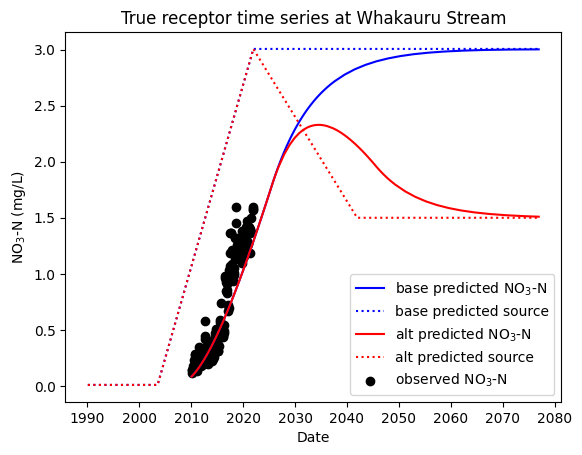

In [30]:
predict_start = (ndata.index.min() - ndata.index.max()).days / 365.25
predict_stop = 55

base_receptor = predict_future_conc_bepm(
    once_and_future_source_conc=base_scenario_source_conc,
    predict_start=predict_start, predict_stop=predict_stop,
    mrt_p1=mrt_p1, frac_p1=frac_p1, f_p1=f_p1, f_p2=f_p2, mrt=mrt, mrt_p2=mrt_p2,
    fill_value=min_conc,
    fill_threshold=0.05, precision=2, pred_step=0.01)

receptor = predict_future_conc_bepm(
    once_and_future_source_conc=alt_scenario_source_conc,
    predict_start=predict_start, predict_stop=predict_stop,
    mrt_p1=mrt_p1, frac_p1=frac_p1, f_p1=f_p1, f_p2=f_p2, mrt=mrt, mrt_p2=mrt_p2,
    fill_value=min_conc, fill_threshold=0.05, precision=2, pred_step=0.01)

# plot the true receptor time series
fig, ax = plt.subplots()
for rec, source, c, lab in zip([base_receptor, receptor], [base_scenario_source_conc, alt_scenario_source_conc],
                               ['blue', 'red', ], ['base', 'alt', ]):
    x = np.array([ndata.index.max().date() + datetime.timedelta(days=e * 365) for e in rec.index])
    ax.plot(x, rec, color=c, label=f'{lab} predicted NO$_{3}$-N')
    idx = source.index >= predict_start - 20
    x = np.array([ndata.index.max().date() + datetime.timedelta(days=e * 365) for e in source.index])
    ax.plot(x[idx], source[idx], color=c, ls=':', label=f'{lab} predicted source')
ax.scatter(ndata.index, ndata['n'], label='observed NO$_{3}$-N', c='k')
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('True receptor time series at Whakauru Stream')
ax.legend()
plt.show()

## Step 5: Estimate the detection power of the monitoring network

Looking at the "true" receptor time series in Whakauru Stream we can see that our alternative scenario will yield a significant decrease from the no change scenario.  In addition, we can clearly see that there will be a decrease in the concentration of NO$_{\text{3}}$-N in the stream.  We can therefore ask the question "what is the probability of detecting a reduction in the NO$_{\text{3}}$-N concentrations in the future?"

We are going to assess detection power of:
* sampling quarterly and monthly (4, 12 samples per year)
* sampling for 10, 15, 20, and 30 years

In [31]:
dpc = DetectionPowerSlope(
    significance_mode='n-section-mann-kendall', nsims=1000, min_p_value=0.05, min_samples=10,
    expect_slope=(1, -1), nparts=2, mpmk_check_step=5)

nsamples_per_year = [4, 12, 24, 52]
sampling_durations = [5, 10, 15, 20, 30]

out_data = []

ts_sampler = interp1d(receptor.index, receptor.values)

for nsamp in nsamples_per_year:
    for dur in sampling_durations:
        idv = f'{nsamp}_{dur}'
        in_conc = ts_sampler(np.arange(0, dur + 1 / nsamp, 1 / nsamp))
        out = dpc.power_calc(
            idv=idv,
            error=input_error,
            true_conc_ts=in_conc,
            seed=1,  # setting the seeds ensures that the process is reproducible

            # the following data is passed right to the output pd.Series
            nsamples_per_year=nsamp,
            sampling_duration=dur,
        )
        out_data.append(out)

out_data = pd.DataFrame(out_data).set_index('idv')

print('an example of the output data')
print(out_data.head())



an example of the output data
      power  max_conc  max_conc_time     error  seed python_error  \
idv                                                                 
4_5     0.0  1.970386             20  0.171609     1         None   
4_10    0.0  2.294754             40  0.171609     1         None   
4_15    7.6  2.328326             50  0.171609     1         None   
4_20   67.9  2.328326             50  0.171609     1         None   
4_30  100.0  2.328326             50  0.171609     1         None   

      nsamples_per_year  sampling_duration  
idv                                         
4_5                   4                  5  
4_10                  4                 10  
4_15                  4                 15  
4_20                  4                 20  
4_30                  4                 30  


### Plot the detection power

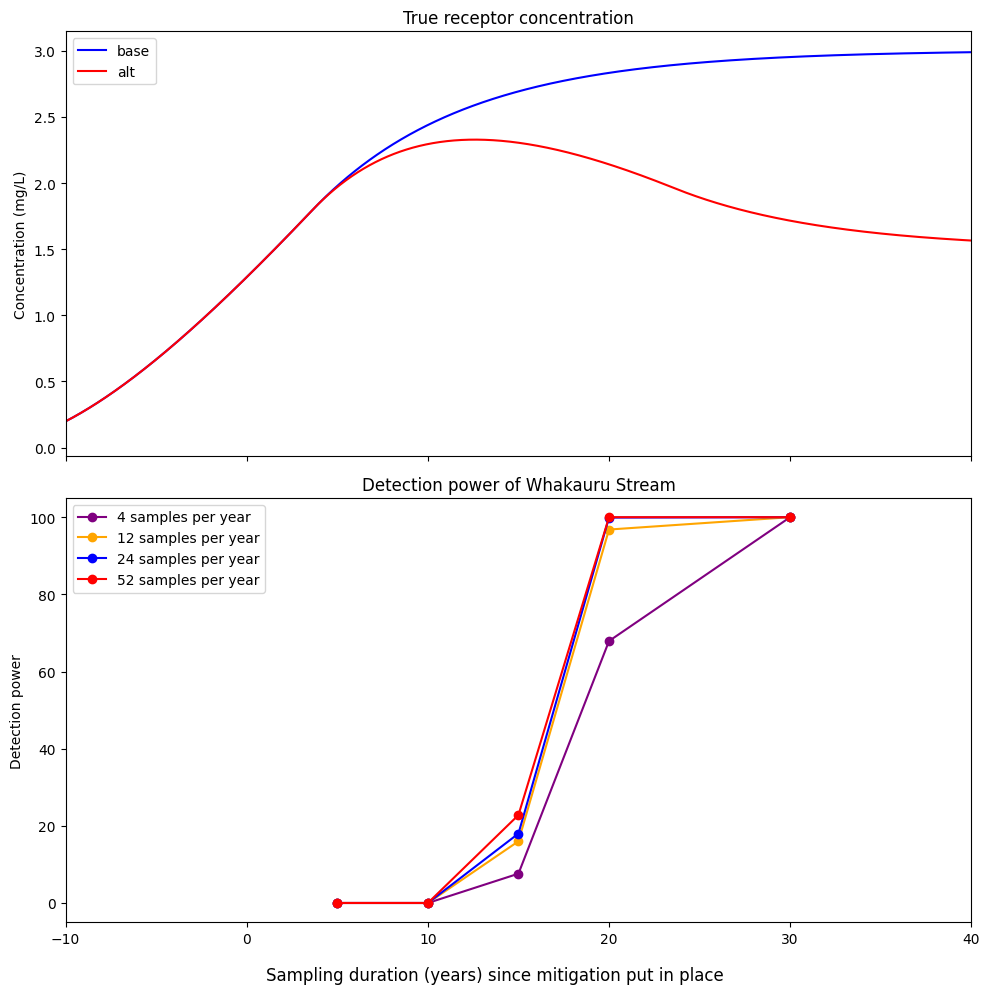

In [32]:
fig, (ax_conc, ax) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

ax_conc.set_title('True receptor concentration')
ax_conc.plot(base_receptor.index, base_receptor.values, label='base', c='b')
ax_conc.plot(receptor.index, receptor.values, label='alt', c='r')
ax_conc.set_ylabel('Concentration (mg/L)')
ax_conc.legend(loc='upper left')

ax.set_title('Detection power of Whakauru Stream')
for nsamp, c in zip(nsamples_per_year, ['purple', 'orange', 'blue', 'red']):
    power = []
    duration = []
    for dur in sampling_durations:
        idv = f'{nsamp}_{dur}'
        power.append(out_data.loc[idv, 'power'])
        duration.append(dur)
    ax.plot(duration, power, label=f'{nsamp} samples per year', color=c, marker='o')
ax.set_ylabel('Detection power')
ax.legend(loc='upper left')
ax.set_xlim(-10, 40)
fig.supxlabel('Sampling duration (years) since mitigation put in place')
fig.tight_layout()

plt.show()

## Running Steps 3-5 using the AutoDetection Power
We can run steps 3-5 with the AutoDetect classes.  These classes will automatically run the steps above and return the detection power for a range of sampling frequencies and durations, but it is more prone to user error.

In [33]:
auto_dpc = AutoDetectionPowerSlope(
    significance_mode='n-section-mann-kendall', nsims=1000, min_p_value=0.05, min_samples=10,
    expect_slope=(1, -1), nparts=2, mpmk_check_step=5)

auto_outdata = []
for nsamp in nsamples_per_year:
    for dur in sampling_durations:
        idv = f'{nsamp}_{dur}'
        out = auto_dpc.power_calc(
            idv=idv,
            error=input_error,
            mrt_model='binary_exponential_piston_flow',
            samp_years=dur,
            samp_per_year=nsamp,
            implementation_time=20,
            initial_conc=init_conc,
            target_conc=target_conc,
            # 15% reduction from source concentration at time 0 to make it directly comparable to the other method.
            prev_slope=prev_slope,
            max_conc_lim=max_conc,
            min_conc_lim=min_conc,
            mrt=mrt,
            mrt_p1=mrt_p1,
            frac_p1=frac_p1,
            f_p1=f_p1,
            f_p2=f_p2,
            #
            seed=1,
        )
        auto_outdata.append(out)

auto_outdata = pd.DataFrame(auto_outdata).set_index('idv')
if np.allclose(auto_outdata.power, out_data.loc[auto_outdata.index].power, atol=5):
    print('The power values are the same (within 5%, rounding errors)')
else:
    for k in auto_outdata.index:
        print('idv', 'auto', 'manual')
        print(k, auto_outdata.loc[k, 'power'], out_data.loc[k, 'power'])
    raise ValueError('The power values are different')


The power values are the same (within 5%, rounding errors)
